**Table of contents**<a id='toc0_'></a>    
- [OHP Experience](#toc1_)    
  - [I Setting](#toc1_1_)    
  - [II Alpy data](#toc1_2_)    
    - [II.1 Collecting the data](#toc1_2_1_)    
      - [II.1.1 Choosing the target](#toc1_2_1_1_)    
    - [II.2 Analysis and calibration](#toc1_2_2_)    
      - [II.2.1 Useful stuff](#toc1_2_2_1_)    
      - [II.2.2 Correcting image](#toc1_2_2_2_)    
      - [II.2.3 Flat correction](#toc1_2_2_3_)    
      - [II.2.4 Calibration](#toc1_2_2_4_)    
    - [II.3 Lamp spectra correlation](#toc1_2_3_)    
    - [II.4 Functions](#toc1_2_4_)    
  - [III Echelle data](#toc1_3_)    
  - [IV Flux normalization](#toc1_4_)    
    - [IV.1 Zero Airmass](#toc1_4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***

# <a id='toc1_'></a>[OHP Experience](#toc0_)

## <a id='toc1_1_'></a>[I Setting](#toc0_)

Import packages

In [17]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import curve_fit

# definition of function type to use in docstring of functions
FUNC_TYPE = type(abs)

## <a id='toc1_2_'></a>[II Alpy data](#toc0_)

### <a id='toc1_2_1_'></a>[II.1 Collecting the data](#toc0_)

Data are in the folder `proj_3/data_files/`. They are organized into five folders (corresponding to the nights of observation). In each one of them there are other folders with the name of the observed object, that contain, in addition to the data of the corresponding target, also an acquisition for the calibration lamp. Only one flat per night was taken.

All data are reported in the file `proj_3/data_files/objs_per_night.json`. Hence, script extracts and collects these data from the file for first.

In [18]:

def data_extraction(path_file: str) -> dict:
    """Extracting data from a .json file

    :param path_file: path of the data file
    :type path_file: str
    
    :return: data organized into nights of aquisition and objects
    :rtype: dict
    """
    # opening the file
    with open(path_file) as f:
        data_file = f.read()
    # converting in a python dictonary
    data_file = json.loads(data_file)
    return data_file

# names for the selection of the night observation
NIGHTS = [f'0{i}_night' for i in range(1,6)]

# taking path of the current folder
# PWD = os.path.dirname(os.path.realpath(__file__))
PWD = os.getcwd()
# path of the project folder
PROJECT_FOLDER = os.path.split(PWD)[0]
# path of the data folder
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data_files')
# path of calibration folder
CAL_FOLDER = os.path.join(DATA_FOLDER, 'calibration')
# path of results folder
RESULT_FOLDER = os.path.join(PROJECT_FOLDER, 'results')

# file with objects collection
OBJ_FILE = os.path.join(DATA_FOLDER, 'objs_per_night.json')

# extracting data
DATA_ALL = data_extraction(OBJ_FILE)

def collect_fits(night: int, obj: str, cutignore: bool = False) -> tuple[list,np.ndarray | None]:
    """Collecting data fits for a chosen night observation
    and object.

    :param night: index of chosen night
    :type night: int
    :param obj: name of the object
    :type obj: str
    
    :return: the list with data fit of that object in that night and section limits for the images
    :rtype: list
    """
    cut = np.loadtxt(os.path.join(DATA_FOLDER, NIGHTS[night], obj, 'cut_indicies.txt'), dtype=int, unpack=False) if cutignore == False else None
    return DATA_ALL[NIGHTS[night]][obj], cut

def data_file_path(night: int, obj: str, data_file: str) -> str:
    return os.path.join(DATA_FOLDER, NIGHTS[night], obj , data_file + '.fit')


#### <a id='toc1_2_1_1_'></a>[II.1.1 Choosing the target](#toc0_)

For the first analysis I chose data acquired the first night for the _Beta Lyrae_ star 

In [19]:
# selecting the observation night
sel_obs = 0
# choosing the object
sel_obj = 'betaLyr'
# collecting data fits for that object
obj, lims = collect_fits(sel_obs, sel_obj)
print(obj)

obj_fit, obj_lamp = obj 
lims_fit, lims_lamp = lims

# appending the path
obj_fit = data_file_path(sel_obs, sel_obj, obj_fit)
obj_lamp = data_file_path(sel_obs, sel_obj,obj_lamp)

print(obj_fit)
print(obj_lamp)


['betaLyr_alpy_26072022_0250', 'betaLyr_alpy_lamp_26072022_0250']
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_26072022_0250.fit
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_lamp_26072022_0250.fit


### <a id='toc1_2_2_'></a>[II.2 Analysis and calibration](#toc0_)

#### <a id='toc1_2_2_1_'></a>[II.2.1 Useful stuff](#toc0_)

I implemented some functions to display images or plots.

In [20]:

##*
def fastplot(x: np.ndarray, y: np.ndarray, numfig: int = None, fmt: str = '-', title: str = '', labels: list[str] = ['',''], dim: list[int] = [10,7]) -> None:
    """Function to display a plot quickly.

    You can choose to make a simple plot or adding some stuff.

    (I wrote it only because of my laziness in writing code).

    :param x: Data on x axis
    :type x: np.ndarray
    :param y: Data on y axis
    :type y: np.ndarray
    :param numfig: figure number, defaults to None
    :type numfig: int, optional
    :param title: title of the figure. default to ' '
    :type title: str, optional
    :param labels: axes label [x,y] format, defaults to ['','']
    :type labels: list[str], optional
    :param dim: figure size, defaults to [10,7] 
    :type dim: list[int], optional
    """
    xl,yl = labels
    plt.figure(numfig,figsize=dim)
    plt.title(title)
    plt.plot(x,y,fmt)
    plt.xlabel(xl)
    plt.ylabel(yl)



##*
def showfits(data: np.ndarray, v: int = -1, title: str = '', n: int = None, dim: list[int] = [10,7]) -> None:
    """Function to display the fits image.
    
    You can display simply the image or set a figure number and a title.

    :param data: image matrix of fits file
    :type data: np.ndarray
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional
    """
    plt.figure(n,figsize=dim)
    plt.title(title)
    if v == 1 : color = 'viridis'
    elif v == 0 : color = 'gray'
    else : color = 'gray_r'
    plt.imshow(data, cmap=color)
    plt.colorbar(orientation='horizontal')
##*


#### <a id='toc1_2_2_2_'></a>[II.2.2 Correcting image](#toc0_)

After collecting data and displaying the spectrum through the `get_data_fit()` function, correction for the angle is done

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-26T00:48:04 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	50.0 \ Exposure time in seconds
EXPOSURE =	50.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-9.07 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning facto

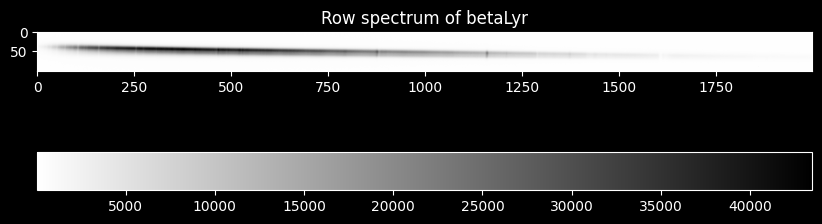

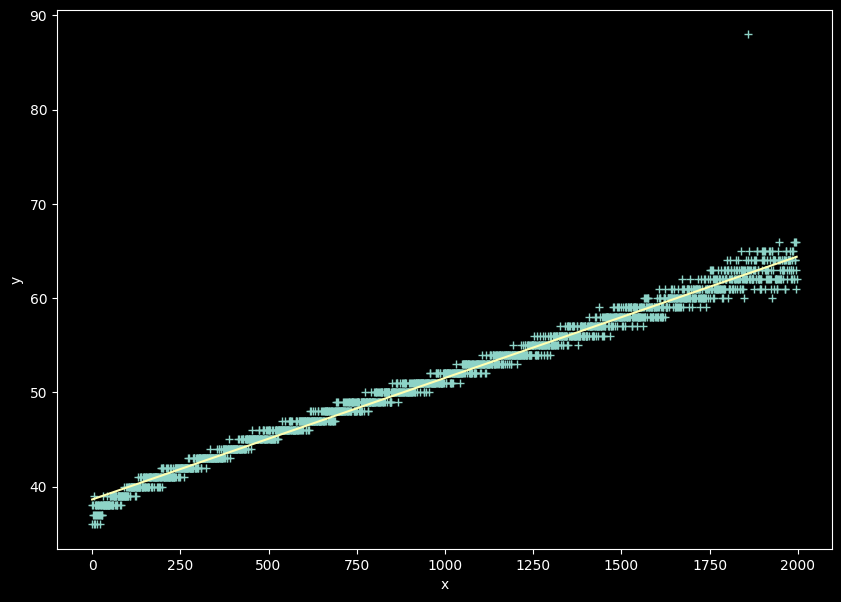

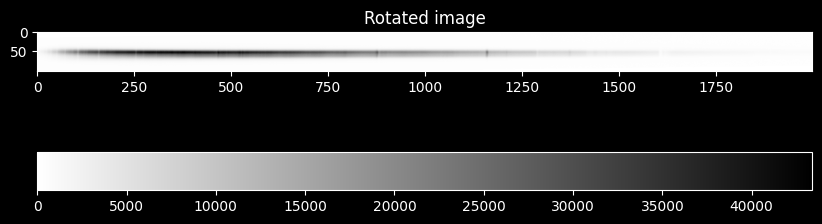

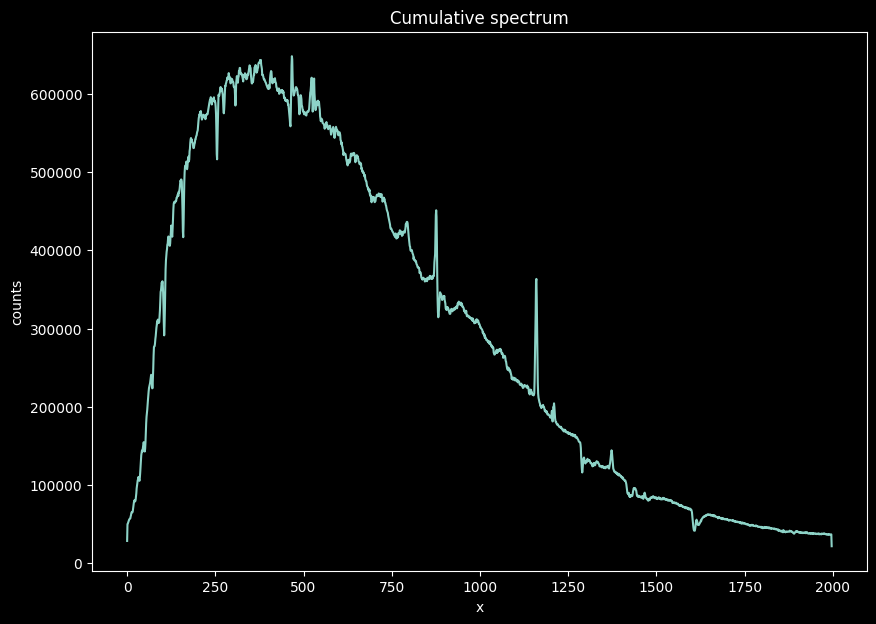

In [21]:
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from scipy.signal import correlate
import scipy.ndimage as ndimage

def hotpx_remove(data: np.ndarray) -> np.ndarray:
    """Removing hot pixels from the image
    
    The function replacing `NaN` values from
    the image if there are.
    
    I did not implement this function myself, 
    I took it from [*astropy documentation*](https://docs.astropy.org/en/stable/convolution/index.html)

    :param data: spectrum data
    :type data: np.ndarray
    
    :return: spectrum data without `NaN` values
    :rtype: np.ndarray
    """
    # checking the presence of `NaNs`
    if True in np.isnan(data):
        # building a gaussian kernel for the interpolation
        kernel = Gaussian2DKernel(x_stddev=1)
        # removing the `NaNs`
        data = interpolate_replace_nans(data, kernel)
    return data

##* 
def get_data_fit(path: str, lims: list[int | None] = [None,None,None,None], hotpx: bool = True, v: int = -1, title: str = '', n: int = None, dim: list[int] = [10,7], display_plots: bool = True) -> tuple:
    """Function to open fits file and extract data.
    
    It brings the path and extracts the data, giving a row image.
    
    You can set a portion of image and also the correction for hotpx.

    It calls the functions: 
      - `hotpx_remove()`
      - `showfits()`

    :param path: path of the fits file
    :type path: str
    :param lims: edges of the fits, defaults to [None,None,None,None]
    :type lims: list[int | None], optional
    :param hotpx: parameter to remove or not the hot pixels, defaults to True
    :type hotpx: bool, optional
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional

    :return: `hdul` list of the chosen fits file and `data` of the spectrum
    :rtype: tuple

    .. note:: `lims` parameter controls the x and y extremes in such the form [lower y, higher y, lower x, higher x]
    """
    # open the file
    hdul = fits.open(path)
    # print fits info
    hdul.info()
    # print header
    hdr = hdul[0].header
    print(' - HEADER -')
    for parameter in hdr:
        hdr_info = f'{parameter} =\t{hdr[parameter]}' 
        comm = hdr.comments[parameter]
        if comm != '': hdr_info = hdr_info + ' \ ' + comm 
        print(hdr_info)
    print()

    # data extraction
    # format -> data[Y,X]
    data = hdul[0].data
    ly,ry,lx,rx = lims
    data = data[ly:ry,lx:rx]
    # hot px correction
    if hotpx == True:
        data = hotpx_remove(data)
    # Spectrum image
    if display_plots == True: showfits(data, v=v,title=title,n=n,dim=dim) 
    return hdul,data
##*

##*
def angle_correction(data: np.ndarray, init: list[float] = [0.9, 0.], angle: float | None = None, display_plots: bool = True) -> tuple[float, np.ndarray]:
    """Function to correct the inclination, rotating the image.
    
    It takes the maximum of each column and does a fit to find 
    the angle with the horizontal. The the image is rotated.

    :param data: image matrix
    :type data: np.ndarray
    :param init: initial values for the fit, defaults to [0.9,0.]
    :type init: list[float], optional

    :return: inclination angle and the corrected data
    :rtype: tuple[float, np.ndarray]
    """
    if angle == None:
        y_pos = np.argmax(data, axis=0)
        x_pos = np.arange(len(y_pos))
        def fitlin(x,m,q):
            return x*m+q
        initial_values = init
        for i in range(3):
            pop, pcov = curve_fit(fitlin,x_pos,y_pos,initial_values)
            m, q = pop
            Dm, Dq = np.sqrt(pcov.diagonal())
            if m == initial_values[0] and q == initial_values[1]: break
            initial_values = pop

        angle = np.arctan(m)*180/np.pi   # degrees
        Dangle = 180/np.pi * Dm/(1+m**2)
        if display_plots == True:
            print(f'\n- Fit results -\nm =\t{m} +- {Dm}\nq =\t{q} +- {Dq}\ncor =\t{pcov[0,1]/Dm/Dq}\nangle =\t{angle} +- ({Dangle/angle*100:.2f} %) deg')
            fastplot(x_pos,y_pos,2,'+')
            fastplot(x_pos,fitlin(x_pos,m,q),2,'-',labels=['x','y'])

    data_rot  = ndimage.rotate(data, angle, reshape=False)
    return angle, data_rot
##*


hdul, sp_data = get_data_fit(obj_fit, lims=lims_fit, title='Row spectrum of '+sel_obj, n=1)

# correcting for inclination angle
angle, sp_data = angle_correction(sp_data)

showfits(sp_data, title='Rotated image')

plt.show()

# taking the cumulative and plot the spectrum
spectrum = sp_data.sum(axis=0)

fastplot(np.arange(len(spectrum)), spectrum, title='Cumulative spectrum', labels=['x','counts'])

plt.show()


#### <a id='toc1_2_2_3_'></a>[II.2.3 Flat correction](#toc0_)

For the first night the flat was acquired during the observation of _Jupiter_.

['giove_alpy_26072022_0116', 'giove_lamp_alpy_26072022', 'giove_flat_alpy_26072022']
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_alpy_26072022_0116.fit
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_lamp_alpy_26072022.fit
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_flat_alpy_26072022.fit
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_alpy_26072022_0116.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	3276

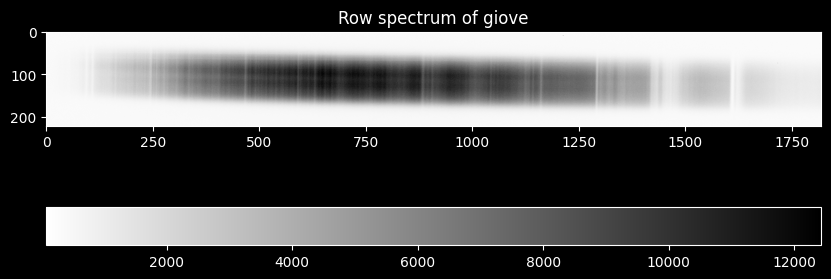

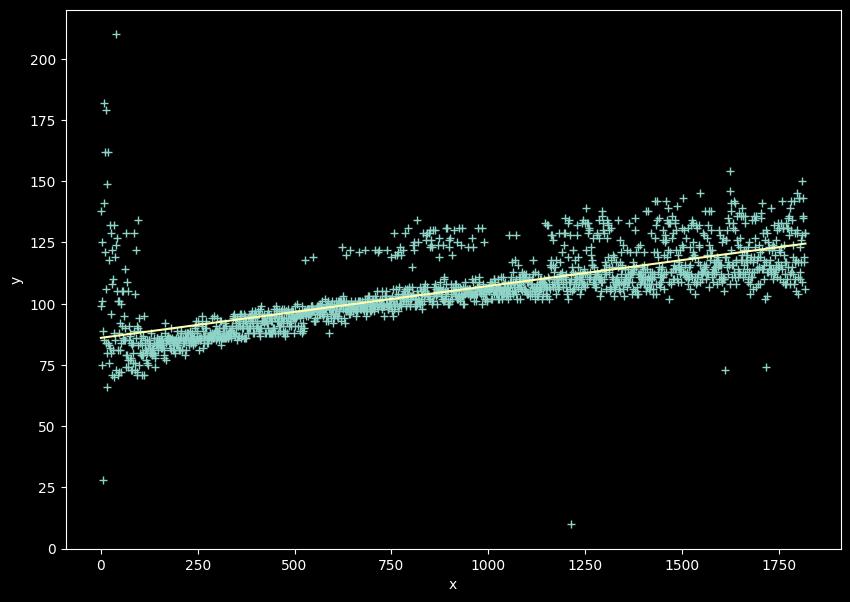

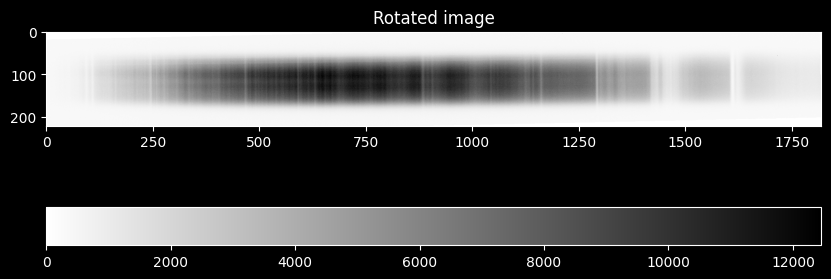

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_flat_alpy_26072022.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-25T23:20:11 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	5.0 \ Exposure time in seconds
EXPOSURE =	5.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-8.51 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning factor in w

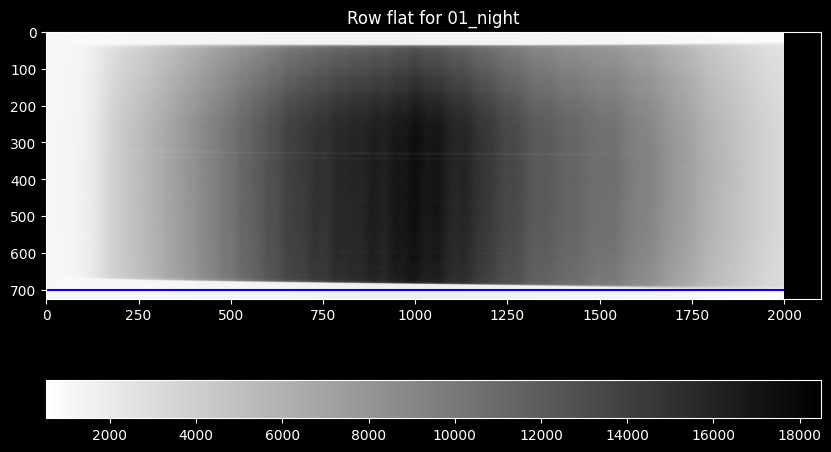

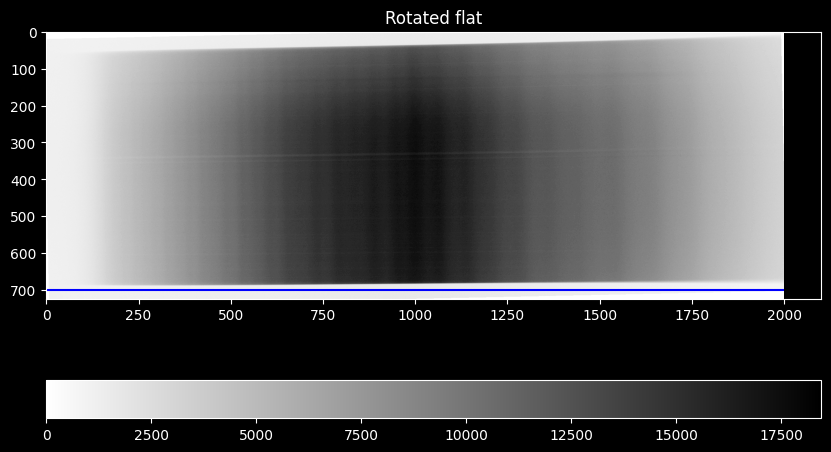

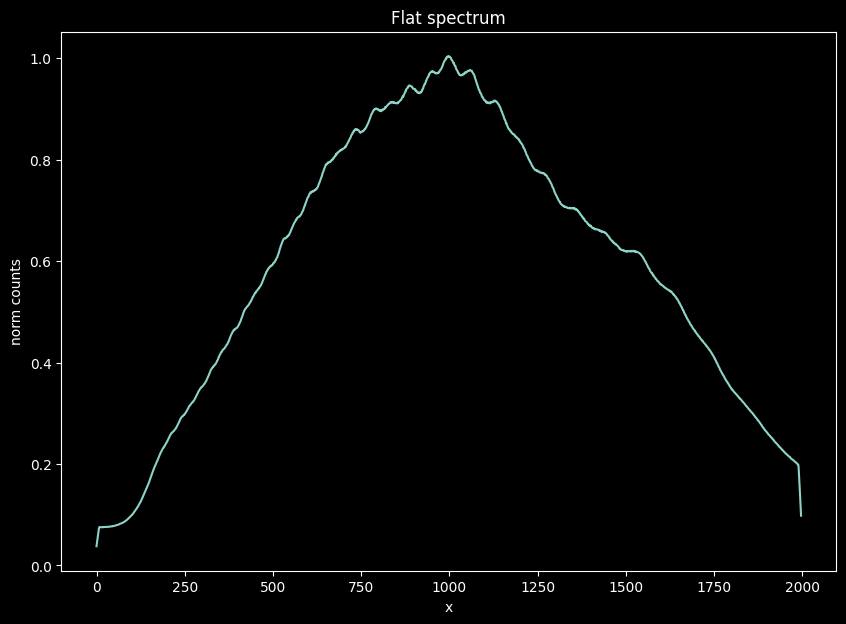

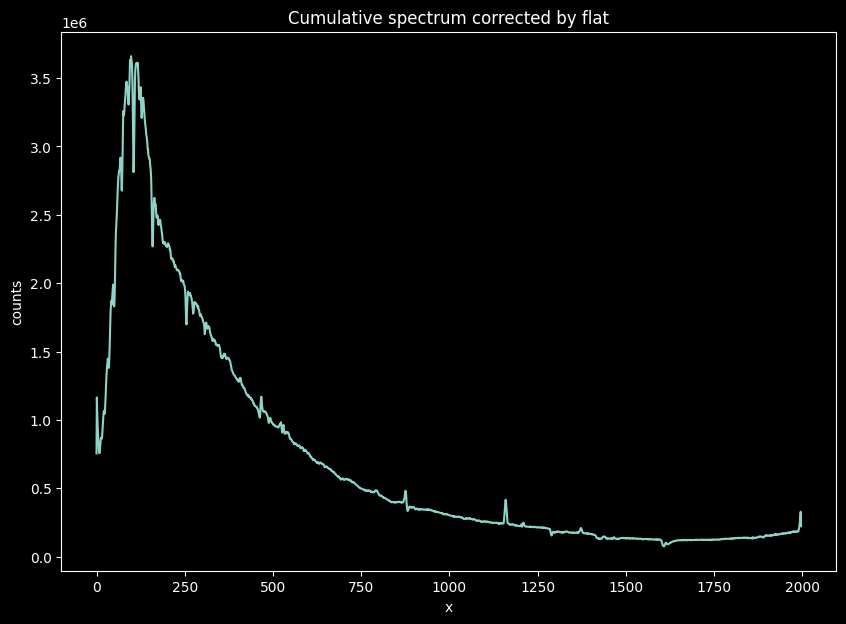

In [22]:
# target for flat of that night
f_sel_obj = 'giove'
# collecting data fits for that object
f_obj, f_lims = collect_fits(sel_obs, f_sel_obj)
print(f_obj)

f_obj_fit, f_obj_lamp, f_obj_flat = f_obj 
f_lims_fit, f_lims_lamp, f_lims_flat = f_lims

# appending the path
f_obj_fit = data_file_path(sel_obs, f_sel_obj, f_obj_fit)
f_obj_lamp = data_file_path(sel_obs, f_sel_obj, f_obj_lamp)
f_obj_flat = data_file_path(sel_obs, f_sel_obj, f_obj_flat)

print(f_obj_fit)
print(f_obj_lamp)
print(f_obj_flat)


f_hdul, f_sp_data = get_data_fit(f_obj_fit, lims=f_lims_fit, title='Row spectrum of '+f_sel_obj, n=1)

# correcting for inclination angle
f_angle, f_sp_data = angle_correction(f_sp_data)

showfits(f_sp_data, title='Rotated image')

plt.show()

# opening flat file
f_hdul_flat, f_sp_flat = get_data_fit(f_obj_flat, lims=f_lims_flat, title='Row flat for '+NIGHTS[sel_obs],n=1)
plt.hlines(699,0,2000, color='blue')

# correcting inclination
#!! Understand the inclination of the flat
_ , f_sp_flat = angle_correction(f_sp_flat,angle=f_angle)

showfits(f_sp_flat, title='Rotated flat')
plt.hlines(699,0,2000, color='blue')
plt.show()

# flat normalization
# find maximum
_, x_max = np.unravel_index(np.argmax(f_sp_flat), f_sp_flat.shape)
# cumulative value
tot_flat = f_sp_flat[:,x_max].sum()
# computing the normalized flat depending on position x
flat_value = f_sp_flat.sum(axis=0)/tot_flat

fastplot(np.arange(len(flat_value)), flat_value, title='Flat spectrum', labels=['x','norm counts'], numfig=1)

# correcting data by flat
if f_lims_flat[2] == lims_fit[2]:
    flt_spectrum = spectrum / flat_value[:len(spectrum)]
    fastplot(np.arange(len(flt_spectrum)), flt_spectrum, title='Cumulative spectrum corrected by flat', labels=['x','counts'],numfig=2)
else:
    flt_spectrum = spectrum
plt.show()

#### <a id='toc1_2_2_4_'></a>[II.2.4 Calibration](#toc0_)

Take one object arbitrally and using the lines of the lamp NeAr in `calibration_lines.txt` fit the transmission function that converts px to lambda.


Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_lamp_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-26T00:51:09 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	10.0 \ Exposure time in seconds
EXPOSURE =	10.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-9.07 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning 

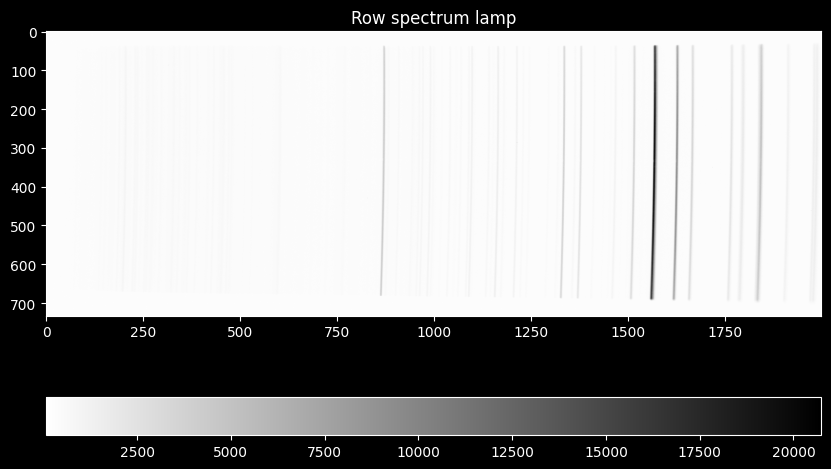

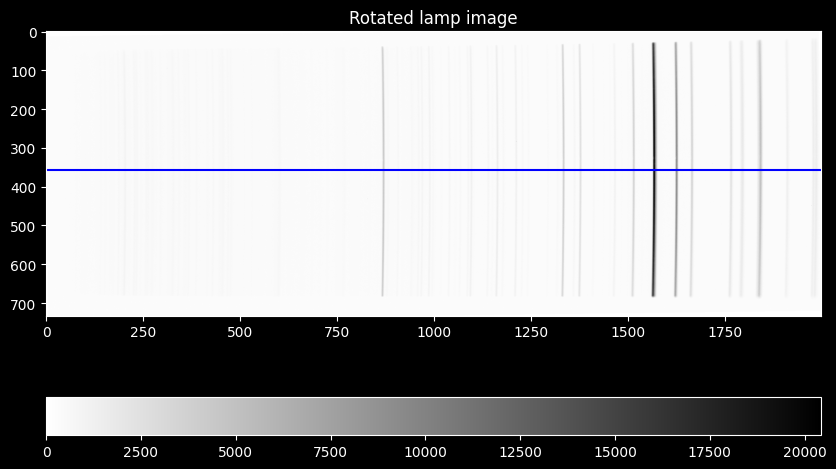

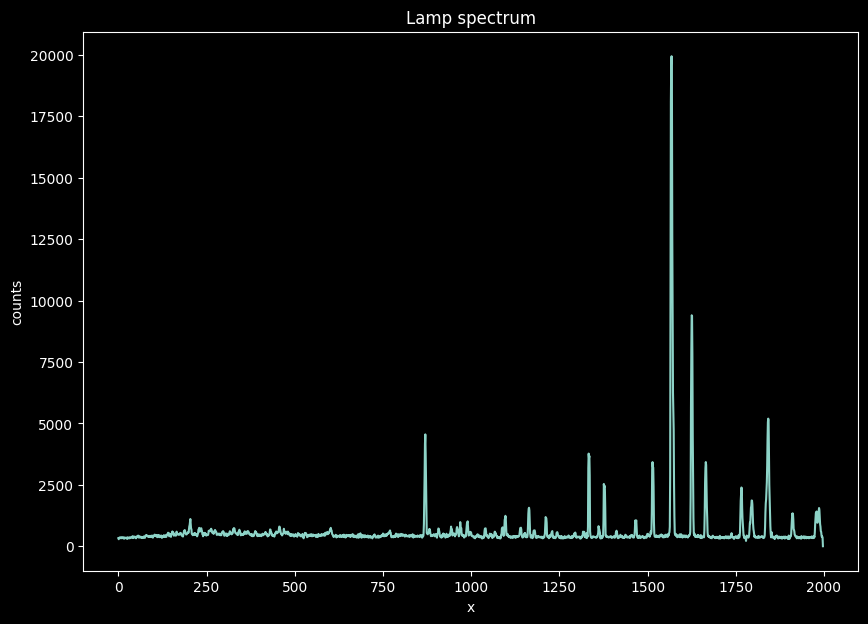

Fit results for 3 params

	y(x) = p0 * x**2 + p1 * x + p2

p0 =	-0.00011467867221603962 +- 3.878830562158414e-06
p1 =	2.636496135121482 +- 0.009670426551852676
p2 =	3651.2385215270324 +- 5.83613488550903
cor01 =	-0.9803056578080219
cor02 =	0.8812851060330918
cor12 =	-0.9541385579397327
Chi_red =	0.434050378988232 +- 5.916079783099616


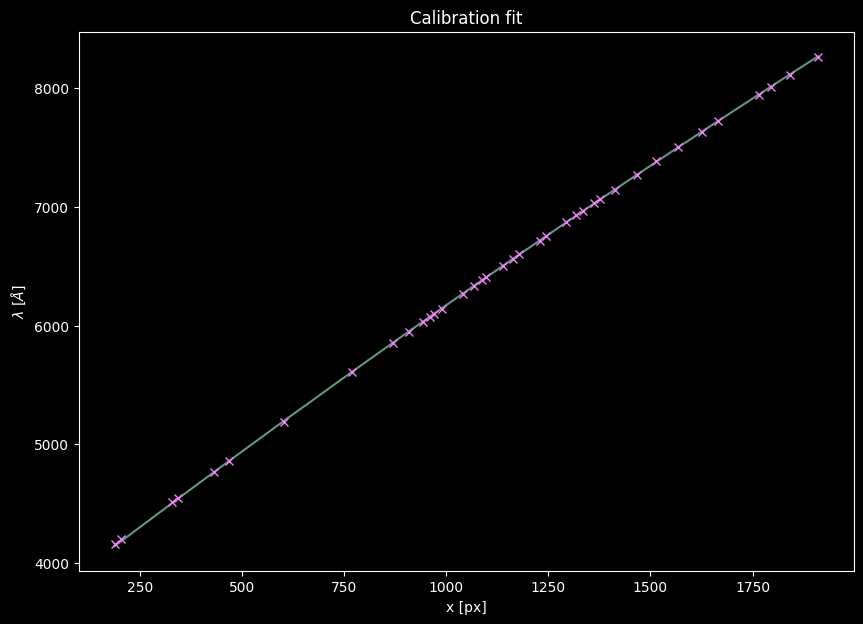

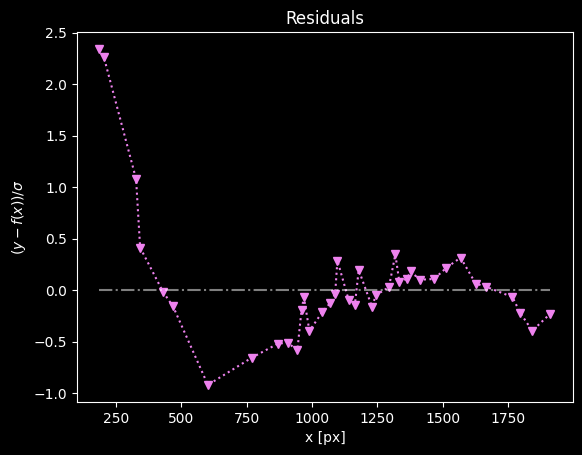

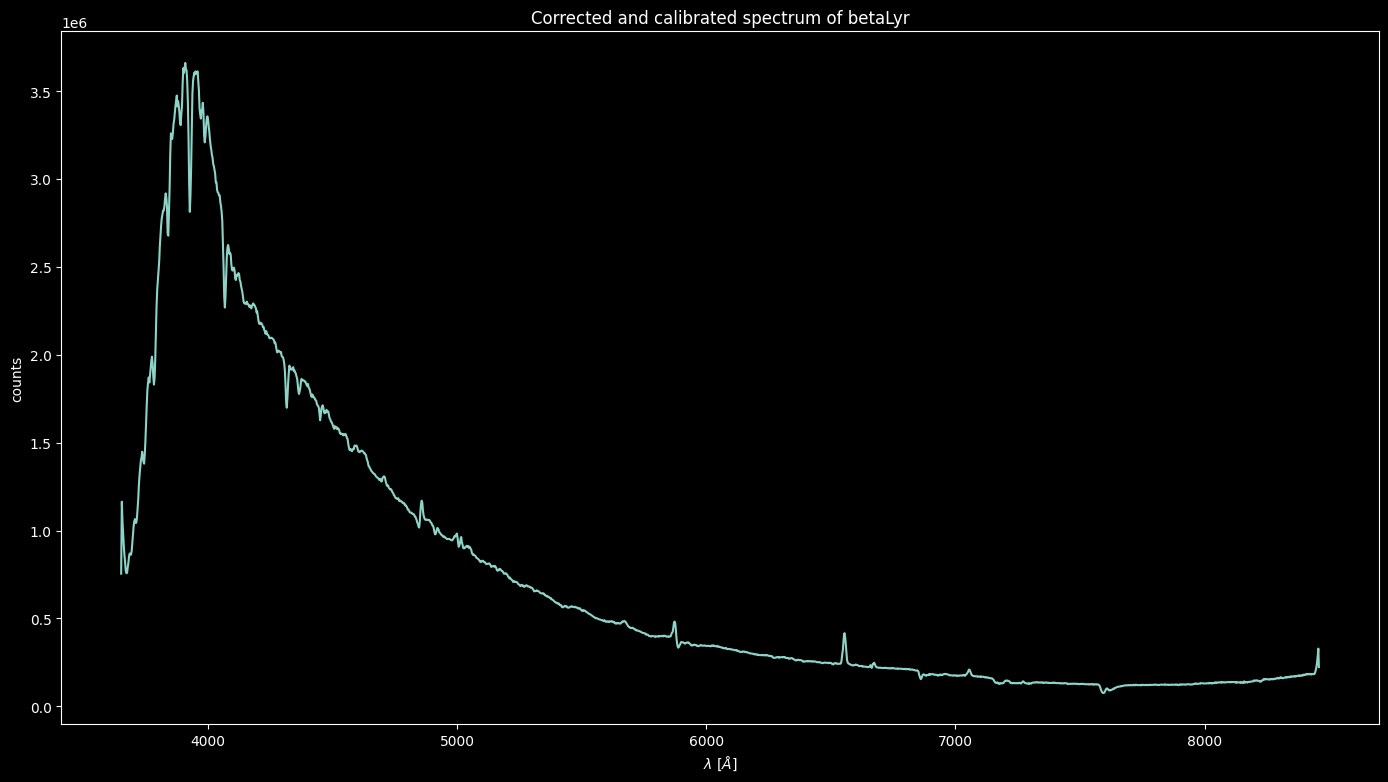

In [23]:
hdul_lamp, sp_lamp = get_data_fit(obj_lamp,lims=lims_lamp, title='Row spectrum lamp',n=1)

_, sp_lamp = angle_correction(sp_lamp, angle=angle)

showfits(sp_lamp, title='Rotated lamp image')

sel_high = int((685.7+26.8) / 2)

plt.hlines(sel_high,0,len(sp_lamp[0])-1,color='blue')

plt.show()

spectrum_lamp = sp_lamp[sel_high]
fastplot(np.arange(len(spectrum_lamp)), spectrum_lamp, title='Lamp spectrum',labels=['x','counts'])

plt.show()

# calibration file
cal_file = os.path.join(os.path.split(obj_fit)[0],'calibration_lines.txt')
# extraction
lines, x, Dx = np.loadtxt(cal_file, unpack=True)

# fit
def fit_func(x,p0,p1,p2):
    return p2 + p1 * x + p0 * x**2

initial_values = [-1.,2.6,3600]
pop, pcov = curve_fit(fit_func,x,lines,initial_values)
for i in range(2):
    initial_values = pop
    Dy = np.sqrt((Dx*pop[1])**2 + (2*Dx*x*pop[0])**2 + pcov[0][1] + pcov[0][2] + pcov[1][2])
    pop, pcov = curve_fit(fit_func,x,lines,initial_values, sigma=Dy)
p0,p1,p2 = pop
Dp0,Dp1,Dp2 = np.sqrt(pcov.diagonal())

sigma = Dy**2 + Dp2**2 + (Dp1*x)**2 + (Dp0*x**2)**2 + pcov[0][1] + pcov[0][2] + pcov[1][2]
chiq = sum((lines - fit_func(x,p0,p1,p2))**2/sigma)

print(f'Fit results for 3 params\n\n\ty(x) = p0 * x**2 + p1 * x + p2\n\np0 =\t{p0} +- {Dp0}\np1 =\t{p1} +- {Dp1}\np2 =\t{p2} +- {Dp2}\ncor01 =\t{pcov[0][1]/Dp0/Dp1}\ncor02 =\t{pcov[0][2]/Dp0/Dp2}\ncor12 =\t{pcov[2][1]/Dp2/Dp1}')
print(f'Chi_red =\t{chiq/(len(x)-3)} +- {np.sqrt(len(x)-3)}')
cal_func = lambda x : fit_func(x,p0,p1,p2)

plt.figure(figsize=[10,7])
plt.title('Calibration fit')
plt.errorbar(x,lines,xerr=Dx,fmt='x',color='violet')
plt.plot(x,cal_func(x),alpha=0.7)
# plt.plot(x,cal_func(x)+np.sqrt(sigma-(Dx*p1)**2),'-.', color='gray',alpha=0.7)
# plt.plot(x,cal_func(x)-np.sqrt(sigma-(Dx*p1)**2),'-.', color='gray',alpha=0.7)
plt.xlabel('x [px]')
plt.ylabel('$\lambda$ [$\AA$]')

plt.figure()
plt.title('Residuals')
plt.plot(x,(lines-cal_func(x))/np.sqrt(sigma),'v:',color='violet')
plt.hlines(0,min(x),max(x),linestyles='-.',alpha=0.5)
plt.xlabel('x [px]')
plt.ylabel('$(y-f(x))/\sigma$')

plt.show()



lengths = cal_func(np.arange(len(flt_spectrum)))

fastplot(lengths,flt_spectrum,title='Corrected and calibrated spectrum of '+sel_obj,labels=['$\lambda$ [$\AA$]','counts'],dim=[17,9])

plt.show()

### <a id='toc1_2_3_'></a>[II.3 Lamp spectra correlation](#toc0_)


['vega_alby_26072022_0327', 'vega_alby_lamp_26072022_0327']
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/vega/vega_alby_26072022_0327.fit
/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/vega/vega_alby_lamp_26072022_0327.fit
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/vega/vega_alby_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-26T01:25:25 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	5.0 \ Exposure time i

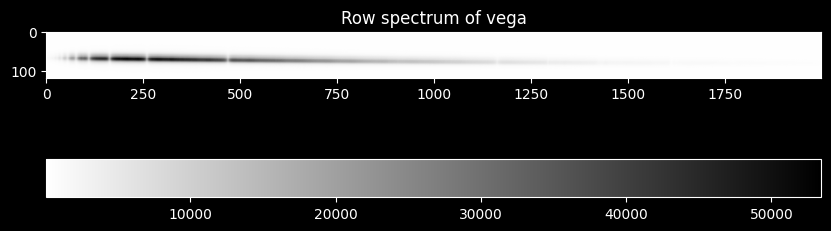

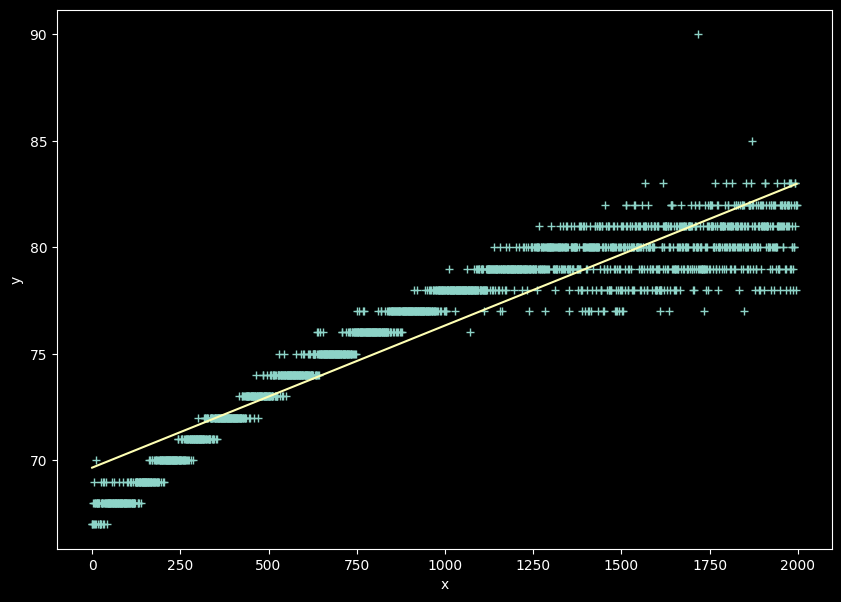

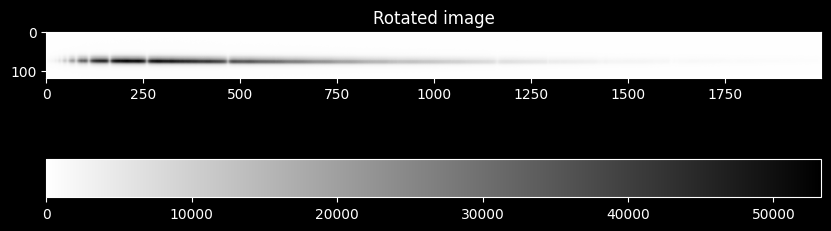

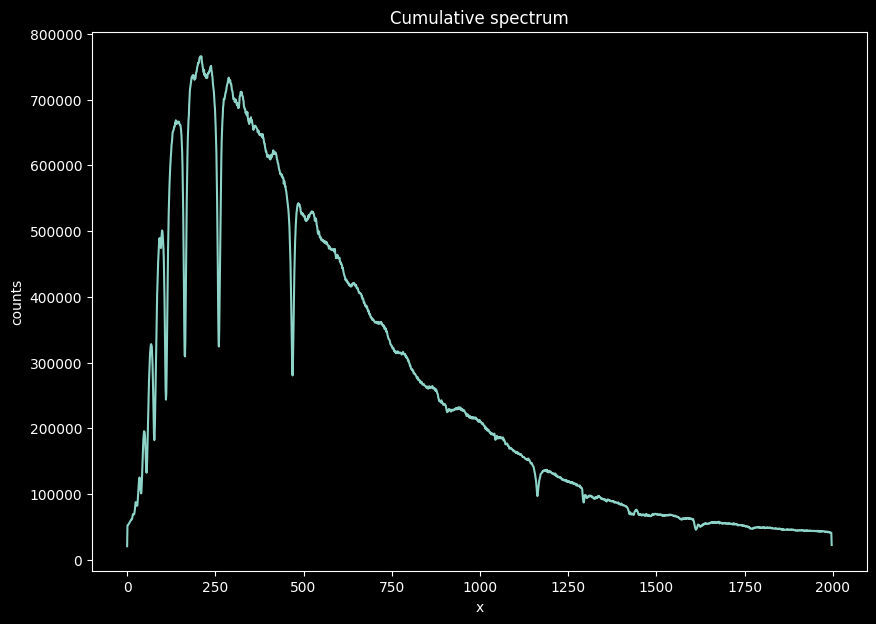

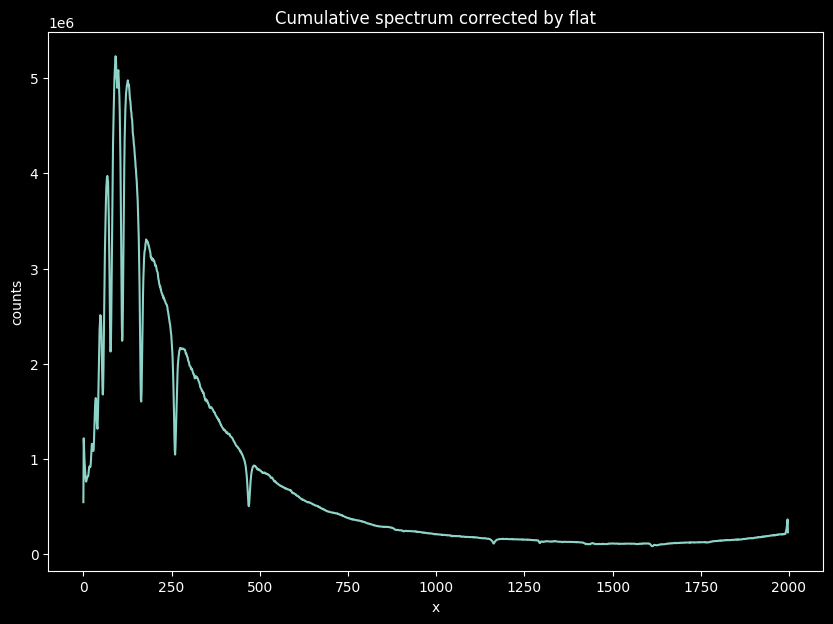

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/vega/vega_alby_lamp_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-26T01:28:11 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	10.0 \ Exposure time in seconds
EXPOSURE =	10.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-10.040000000000001 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ 

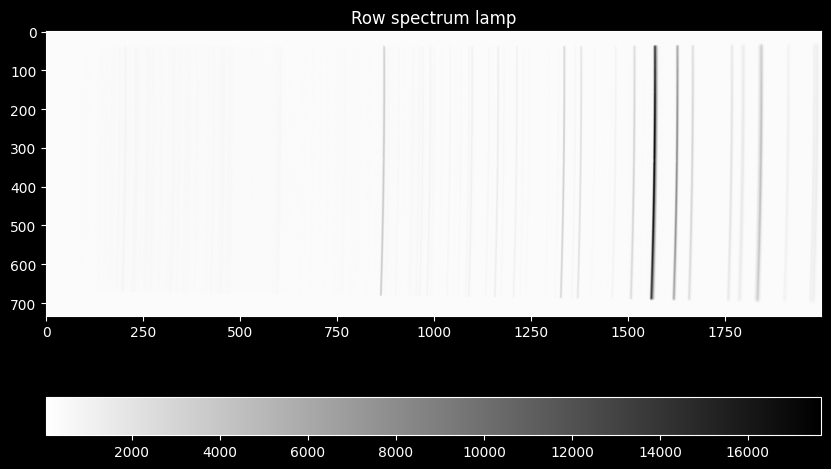

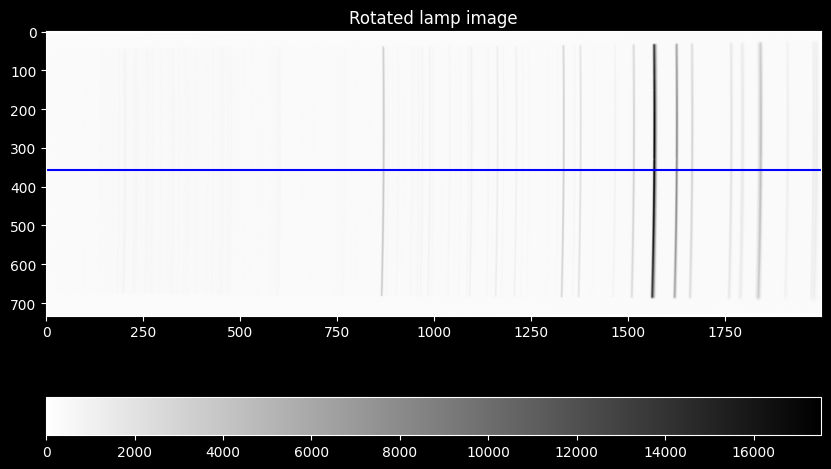

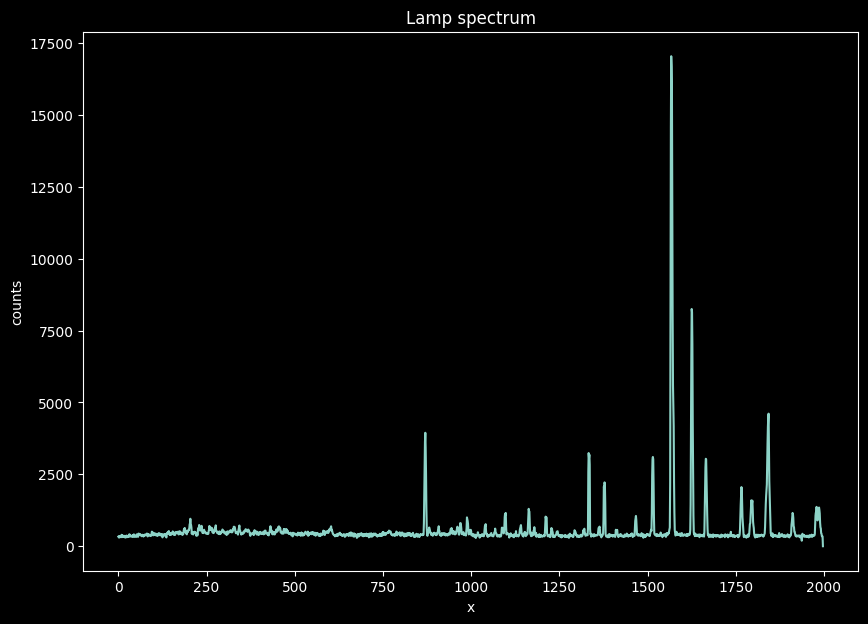

max(|auto_corr - corr|) = 0


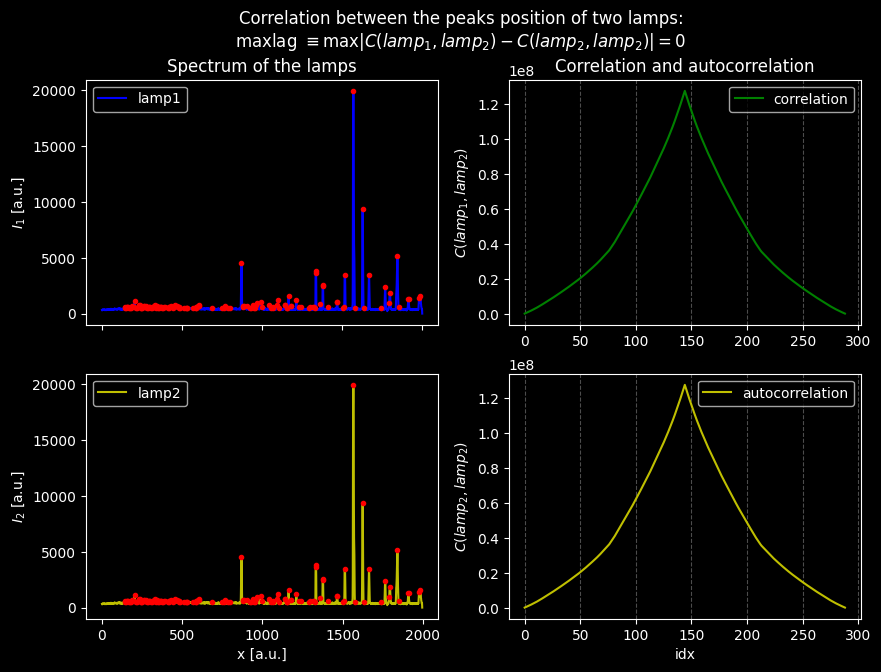

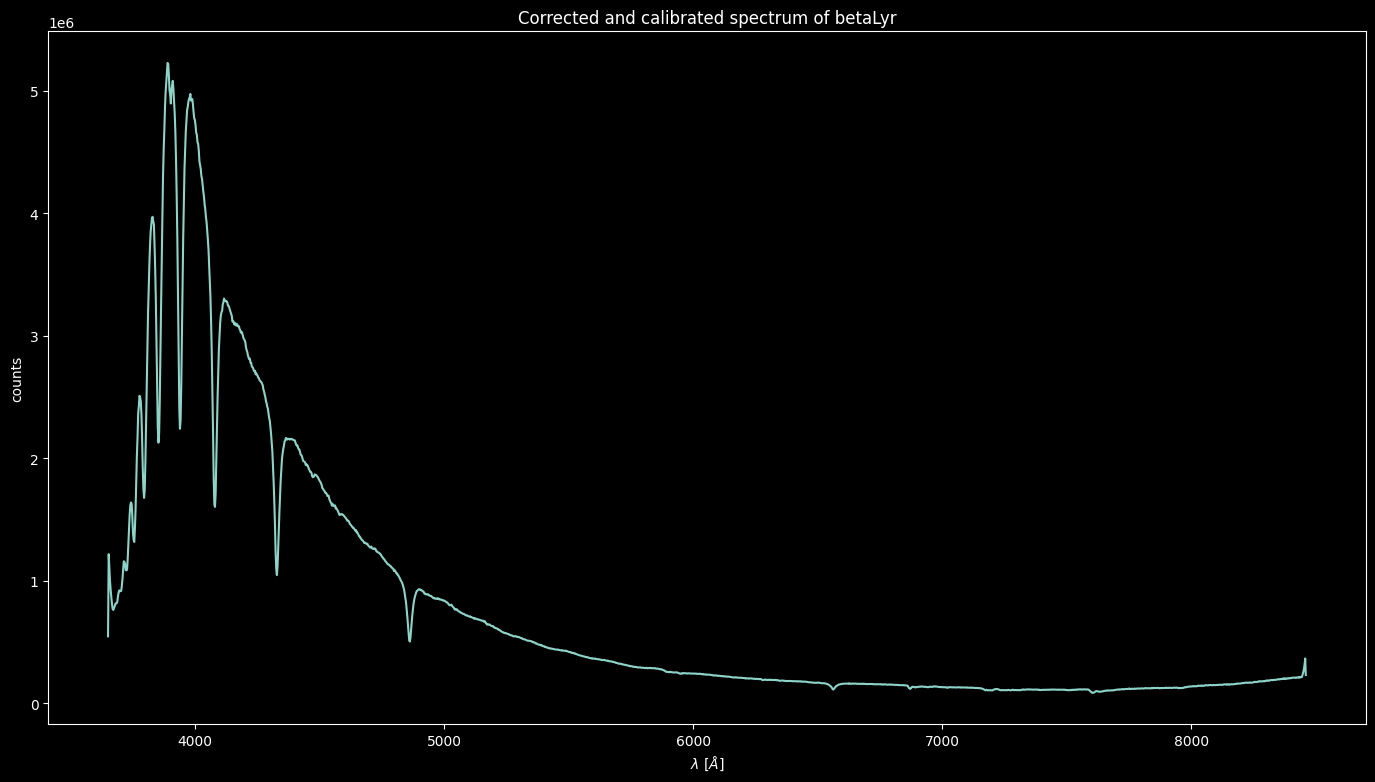

In [24]:
# selecting an other object
sel_obj2 = 'vega'
# collecting data fits for that object
obj2, lims2 = collect_fits(sel_obs, sel_obj2)
print(obj2)

obj2_fit, obj2_lamp = obj2 
lims2_fit, lims2_lamp = lims2

# appending the path
obj2_fit = data_file_path(sel_obs, sel_obj2, obj2_fit)
obj2_lamp = data_file_path(sel_obs, sel_obj2,obj2_lamp)

print(obj2_fit)
print(obj2_lamp)

hdul2, sp_data2 = get_data_fit(obj2_fit, lims=lims2_fit, title='Row spectrum of '+sel_obj2, n=1)

# correcting for inclination angle
angle2, sp_data2 = angle_correction(sp_data2)

showfits(sp_data2, title='Rotated image')

plt.show()

# taking the cumulative and plot the spectrum
spectrum2 = sp_data2.sum(axis=0)

fastplot(np.arange(len(spectrum2)), spectrum2, title='Cumulative spectrum', labels=['x','counts'])

plt.show()

# correcting by flat
flt_spectrum2 = spectrum2 / flat_value[:len(spectrum2)]
fastplot(np.arange(len(flt_spectrum2)), flt_spectrum2, title='Cumulative spectrum corrected by flat', labels=['x','counts'],numfig=2)

plt.show()

# lamps correlation
# storing the data of the previous lamp
prev_lamp = spectrum_lamp
# extarcting the ones of the interested lamp
hdul2_lamp, sp_lamp2 = get_data_fit(obj2_lamp,lims=lims2_lamp, title='Row spectrum lamp',n=1)

_, sp_lamp2 = angle_correction(sp_lamp2, angle=angle2)

showfits(sp_lamp2, title='Rotated lamp image')

sel_high = int((685.7+26.8) / 2)

plt.hlines(sel_high,0,len(sp_lamp2[0])-1,color='blue')

plt.show()

spectrum_lamp2 = sp_lamp2[sel_high]
fastplot(np.arange(len(spectrum_lamp2)), spectrum_lamp2, title='Lamp spectrum',labels=['x','counts'])

plt.show()


## Correlation
from scipy.signal import find_peaks
# setting the minimum height for the peaks 
height = 500
# finding the positions of the peaks in lamp spectra
pkslamp1, _ = find_peaks(prev_lamp,height=height)
pkslamp2, _ = find_peaks(spectrum_lamp,height=height)

# computing the correlation and the autocorrelation
corr = np.correlate(pkslamp1,pkslamp2,'full')
autocorr = np.correlate(pkslamp2,pkslamp2,'full')

# computing the max lag
maxlag = np.abs(corr-autocorr).max()
# checking the max lag
if maxlag < 1:
    print(f'max(|auto_corr - corr|) = {maxlag}')
else:
    raise Exception(f'Peaks positions in lamps have to be shifted!\nMAXLAG = {maxlag}')

# plot
plt.figure(figsize=[10,7])
plt.suptitle('Correlation between the peaks position of two lamps:\nmaxlag $\equiv \max{ | C(lamp_1,lamp_2) - C(lamp_2,lamp_2) | } =$' + f'{maxlag}')

plt.subplot(2,2,1)
plt.title('Spectrum of the lamps')
plt.plot(prev_lamp,'b',label='lamp1')
plt.plot(pkslamp1,prev_lamp[pkslamp1],'.r')
plt.ylabel('$I_1$ [a.u.]')
plt.legend()
plt.xticks(np.arange(0,len(prev_lamp),len(prev_lamp)//4),[])
plt.subplot(2,2,3)
plt.plot(spectrum_lamp,'y',label='lamp2')
plt.plot(pkslamp2,spectrum_lamp[pkslamp2],'.r')
plt.ylabel('$I_2$ [a.u.]')
plt.legend()
plt.xlabel('x [a.u.]')


plt.subplot(2,2,2)
plt.title('Correlation and autocorrelation')
plt.plot(corr,'g',label='correlation')
plt.ylabel('$C(lamp_1,lamp_2)$')
plt.grid(axis='x',linestyle='dashed',alpha=0.3)
plt.legend()
# plt.xticks(np.arange(0,len(corr),len(corr)//6),[])
plt.subplot(2,2,4)
plt.plot(autocorr,'y',label='autocorrelation')
plt.ylabel('$C(lamp_2,lamp_2)$')
plt.grid(axis='x',linestyle='dashed',alpha=0.3)
plt.legend()
plt.xlabel('idx')


plt.show()



lengths2 = cal_func(np.arange(len(flt_spectrum2)))


fastplot(lengths2,flt_spectrum2,title='Corrected and calibrated spectrum of '+sel_obj,labels=['$\lambda$ [$\AA$]','counts'],dim=[17,9])

plt.show()

### <a id='toc1_2_4_'></a>[II.4 Functions](#toc0_)


Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-26T00:48:04 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	50.0 \ Exposure time in seconds
EXPOSURE =	50.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-9.07 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning facto

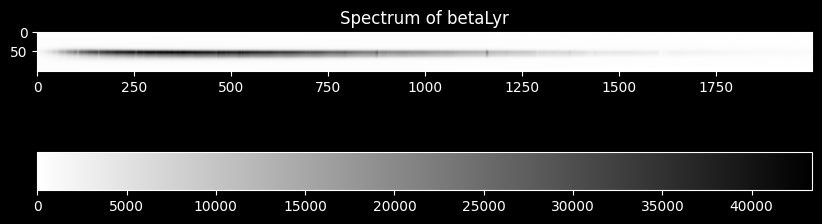

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_alpy_26072022_0116.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-25T23:05:38 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	7.0 \ Exposure time in seconds
EXPOSURE =	7.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	1.0 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning factor in wid

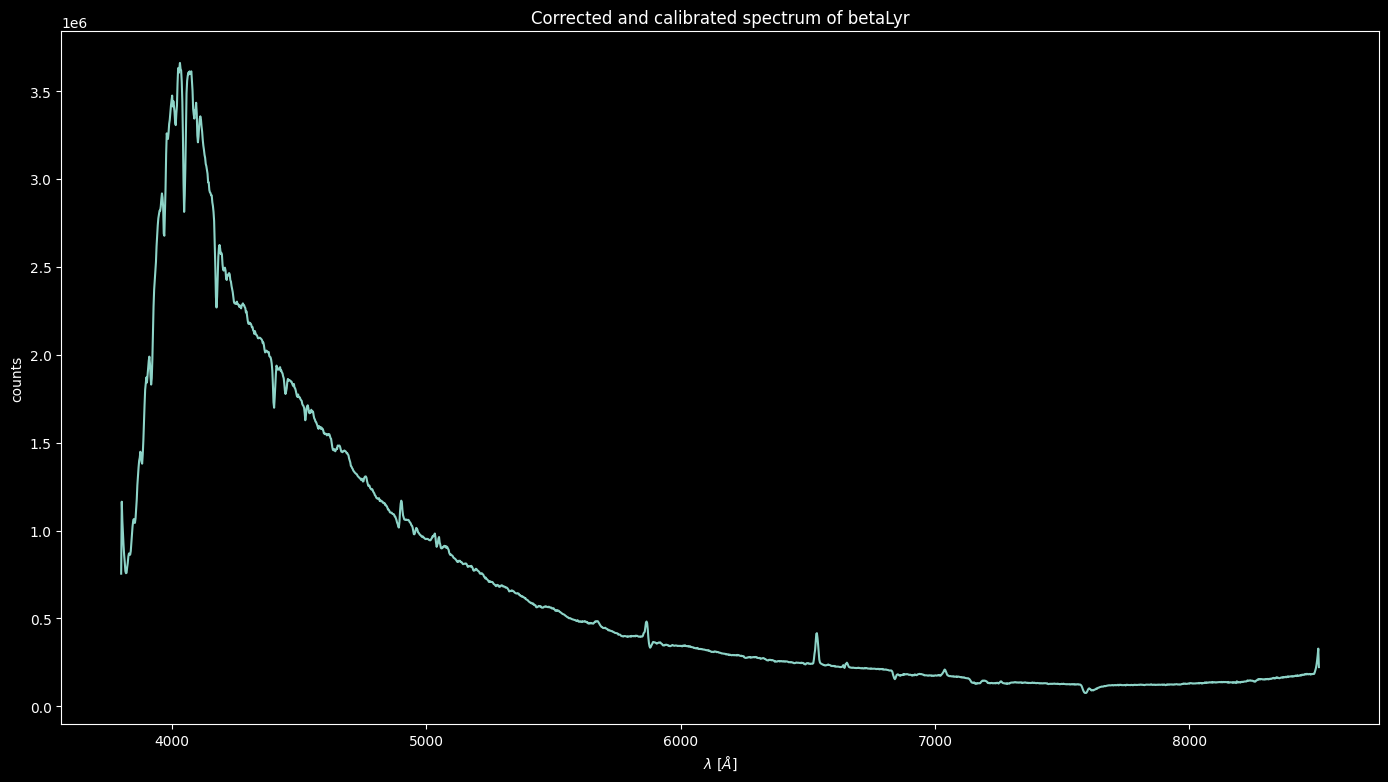

In [25]:

def extract_data(ch_obs: int, ch_obj: str) -> list[str]:
    """Collecting data from data files.
    
    Given a selected observation night and object, the function 
    returns both the paths of the target and the calibration lamp
    (also the flat if there is) and the corrisponding values for 
    the edges of the images. 

    :param ch_obs: chosen obeservation night
    :type ch_obs: int
    :param ch_obj: chosen object name
    :type ch_obj: str
    
    :return: the list with paths and extrema
    :rtype: list
    """
    # only for the first two observation nights Alpy was used
    if ch_obs < 2:
        # extracting informations
        obj, lims = collect_fits(ch_obs, ch_obj)
        # collecting in different variables
        obj_fit, obj_lamp = obj[:2] 
        lims_fit, lims_lamp = lims[:2]

        # appending the path
        obj_fit = data_file_path(ch_obs, ch_obj, obj_fit)
        obj_lamp = data_file_path(ch_obs, ch_obj, obj_lamp)
        
        # storing in `data` list
        #   format is [obj, its extrema, ...]
        data = [obj_fit, lims_fit, obj_lamp, lims_lamp]   
        # condition for the presence of flat
        if ch_obj == 'giove' or ch_obj == 'arturo':
            obj_flat = obj[-1]
            lims_flat = lims[-1]
            obj_flat = data_file_path(ch_obs, ch_obj, obj_flat)
            data += [obj_flat, lims_flat]             
    # for echelle data extraction
    else:
        # extracting informations
        obj, _ = collect_fits(ch_obs, ch_obj, cutignore=True)
        # collecting in different variables
        obj_fit, obj_lamp = obj[:2]
        thor, tung = obj_lamp

        # appending the path
        obj_fit = data_file_path(ch_obs, ch_obj, obj_fit)
        thor = data_file_path(ch_obs, ch_obj, thor)
        tung = data_file_path(ch_obs, ch_obj, tung)
        
        # storing in `data` list
        #   format is [obj, its extrema, ...]
        data = [obj_fit, thor, tung]   
    return data



def get_data(ch_obj: str, obj_fit: str, lims_fit: list[int | None] = [None,None,None,None] , angle: float | None = None, display_plots: bool = False) -> tuple:
    """Extracting the fits data
    The function gets the data of the spectrum from the fits file of a selected target and corrects for the
    inclination, returning the fits information (`hdul`), the spectrum data (`sp_data`) and the angle of
    inclination (`angle`).

    :param ch_obj: chosen object name
    :type ch_obj: str
    :param obj_fit: path of the target
    :type obj_fit: str
    :param lims_fit: extrema of the image
    :type lims_fit: list[int]
    :param angle: the inclination angle to rotate the image. If it is None it will be estimated, defaults to None
    :type angle: float | None, optional
    :param display_plots: if it is True images/plots are displayed, defaults to False
    :type display_plots: bool, optional
    
    :return: fits information, spectrum data, inclination angle 
    :rtype: tuple
    """
    # collecting fits informations and spectrum data
    hdul, sp_data = get_data_fit(obj_fit, lims=lims_fit, title='Row spectrum of '+ ch_obj, n=1, display_plots=display_plots)
    # correcting for inclination angle
    angle, sp_data = angle_correction(sp_data, angle=angle, display_plots=display_plots)
    # condition to display the images/plots
    if display_plots == True:
        showfits(sp_data, title='Rotated image')
        plt.show()
    return hdul, sp_data, angle


def compute_flat(ch_obs: int, display_plots: bool = False) ->  np.ndarray:
    """Evaluating the flat gain
    After extracting the data of the flat acquisition, the function finds the
    maximum and computes the cumulative spectrum over the y axis. Then the 
    gain is extimated for each x coordinate by normalization through the 
    maximum and returned.

    :param ch_obs: chosen observation night
    :type ch_obs: int
    :param display_plots: if it is True images/plots are displayed, defaults to False
    :type display_plots: bool, optional
    
    :return: flat gain for each x coordinate
    :rtype: np.ndarray
    """
    # name of the target for which flat was acquired
    if ch_obs == 0:
        flat_obj = 'giove'  
    elif ch_obs == 1:
        flat_obj = 'arturo'
    # collecting informations for the target and the flat
    obj_fit, lims_fit, _, _, obj_flat, lims_flat = extract_data(ch_obs, flat_obj)
    # extracting target spectrum data and evaluating the inclination angle
    _, _, angle = get_data(flat_obj,obj_fit,lims_fit, display_plots=display_plots)
    # extracting flat spectrum data and correcting for inclination
    _, sp_flat, _ = get_data(flat_obj,obj_flat,lims_flat, angle=angle, display_plots=display_plots)
    
    # flat gain estimation
    # finding the x coordinate for the maximum
    _, x_max = np.unravel_index(np.argmax(sp_flat), sp_flat.shape)
    # computing the cumulative value over the column
    tot_flat = sp_flat[:,x_max].sum()
    # computing the normalized flat depending on position x
    flat_value = sp_flat.sum(axis=0)/tot_flat
    # condition to display the images/plots
    if display_plots == True:
        fastplot(np.arange(len(flat_value)), flat_value, title='Flat spectrum', labels=['x','norm counts'])
        plt.show()

    return flat_value


def calibration(cal_file: str, obj_lamp: str, lims_lamp: list, angle: float, high: int, initial_values: list[float] = [3600, 2.6], display_plots: bool = False) -> FUNC_TYPE:
    """Evaluating the calibration function to pass from x axis units to Armstrong
    From spectrum data of the selected calibration lamp and corrisponding detected lines (obtained from `SpecrteArNeLISA.pdf` file) the function to map positions
    along the x axis in wavelengths is computed. To estimate the parameters a fit for a linear function is implemented.

    :param cal_file: file with calibration lines sampled from the `SpecrteArNeLISA.pdf` file
    :type cal_file: str
    :param obj_lamp: path for the lamp file
    :type obj_lamp: str
    :param lims_lamp: extrema of the lamp image
    :type lims_lamp: list
    :param angle: inclination angle
    :type angle: float
    :param high: y coorfinate at which the spectrum is taken
    :type high: int
    :param initial_values: initial values for the fit, defaults to [3600, 2.6]
    :type initial_values: list[float], optional
    :param display_plots: if it is True images/plots are displayed, defaults to False
    :type display_plots: bool, optional
    
    :return: the calibration function
    :rtype: FUNC_TYPE
    """
    # extracting lamp spectrum and correcting for inclination
    _, sp_lamp = get_data_fit(obj_lamp,lims=lims_lamp, title='Row spectrum lamp', n=1, display_plots=display_plots)
    _, sp_lamp = angle_correction(sp_lamp, angle=angle, display_plots=display_plots)
    # condition to display the images/plots
    if display_plots == True:
        showfits(sp_lamp, title='Rotated lamp image')
        plt.hlines(high,0,len(sp_lamp[0])-1,color='blue')
        plt.show()
    # taking the spectrum of the lamp at `high`
    spectrum_lamp = sp_lamp[high]
    # condition to display the images/plots
    if display_plots == True:
        fastplot(np.arange(len(spectrum_lamp)), spectrum_lamp, title=f'Lamp spectrum at y = {high}',labels=['x','counts'])
        plt.show()

    # fit method
    # defining the linear function for the fit
    def fit_func(x,p0,p1):
        return p0 + p1*x
    # extracting the data for the calibration from `cal_file`
    lines, x, Dx = np.loadtxt(cal_file, unpack=True)
    # running the fit method three times to increase accuracy
    pop, pcov = curve_fit(fit_func,x,lines,initial_values)
    for _ in range(2):
        initial_values = pop
        # esitmating the error over y variable
        Dy = Dx*pop[1]
        pop, pcov = curve_fit(fit_func,x,lines,initial_values, sigma=Dy)
    # extracting values of parameters
    p0,p1 = pop
    Dp0,Dp1 = np.sqrt(pcov.diagonal())
    #! DA CONTROLLARE
    # computing the sigma
    sigma = Dy**2 + Dp0**2 + (Dp1*x)**2 + pcov[0][1]
    chiq = sum((lines - fit_func(x,p0,p1))**2/sigma)
    #!
    # printing the results
    print(f'Fit results for 2 params\np0 =\t{p0} +- {Dp0}\np1 =\t{p1} +- {Dp1}\ncor =\t{pcov[0][1]/Dp0/Dp1*100} %')
    print(f'Chi_red =\t{chiq/(len(x)-2)} +- {np.sqrt(len(x)-2)}')
    
    # defining the calibration function
    cal_func = lambda x : fit_func(x,p0,p1)
    
    # condition to display the images/plots
    if display_plots == True:
        plt.figure(figsize=[10,7])
        plt.title('Calibration fit')
        plt.errorbar(x,lines,xerr=Dx,fmt='x',color='violet')
        plt.plot(x,cal_func(x))
        plt.xlabel('x [px]')
        plt.ylabel('$\lambda$ [$\AA$]')

        plt.figure()
        plt.title('Residuals')
        plt.hlines(0,min(x),max(x),linestyles='-.',alpha=0.5)
        plt.plot(x,(lines-cal_func(x))/np.sqrt(sigma),'v:',color='violet')
        plt.xlabel('x [px]')
        plt.ylabel('$(y-f(x))/\sigma$')

        plt.show()

    return cal_func



def calibrated_spectrum(ch_obs: int, ch_obj: str, flat: list[None] | np.ndarray = [], cal_func: FUNC_TYPE | None = None, display_plots: bool = False) -> tuple:
    """Getting the spectrum of a selceted target for a chosen observation night
    The function extracts fits data for a target and evaluates inclination correction, flat gain and calibration function to return the
    calibrated spectrum. If the flat gain or the calibration function are already computed then one can pass them to the function, 
    avoiding an other estimation.
    
    The function returns fits informations (`hdul`), spectrum image data (`sp_data`), cumulative spectrum (`spectrum`), corrisponding 
    wavelengths (`lenghts`), flat gain (`flat_value`) and calibration function (`cal_func`).
    
    It calls the functions:
      - `extract_data()`
      - `get_data()`
      - `showfits()`
      - `fastplot()`
      - `compute_flat()`
      - `calibration()`
    

    :param ch_obs: chosen observation night
    :type ch_obs: int
    :param ch_obj: chosen ob
    :type ch_obj: str
    :param flat: if the flat gain is not evaluated yet, the flat target name is passed
    :type flat: str | np.ndarray
    :param cal_func: if it is None, the calibration function will be computed, defaults to None
    :type cal_func: FUNC_TYPE | None, optional
    :param display_plots: if it is True images/plots are displayed, defaults to False
    :type display_plots: bool, optional
    
    :return: fits informations, spectrum image data, cumulative spectrum, corrisponding wavelenghts, flat gain and calibration function
    :rtype: tuple
    """
    # collecting data
    obj_fit, lims_fit, obj_lamp, lims_lamp = extract_data(ch_obs, ch_obj)
    # extracting fits data and correcting for inclination
    hdul, sp_data, angle = get_data(ch_obj,obj_fit,lims_fit, display_plots=display_plots)
    if display_plots == False: 
        showfits(sp_data, title='Spectrum of '+ ch_obj)
        plt.show() 

    # computing the cumulative spectrum over columns
    spectrum = sp_data.sum(axis=0)
    if display_plots == True:
        fastplot(np.arange(len(spectrum)), spectrum, title='Cumulative spectrum', labels=['x','counts'])
        plt.show()

    # estimating the flat gain
    flat_value = compute_flat(ch_obs, display_plots=display_plots) if len(flat) == 0 else flat
    # correcting for the flat gain
    spectrum = spectrum / flat_value[:len(spectrum)]
    if display_plots == True:
        fastplot(np.arange(len(spectrum)), spectrum, title='Cumulative spectrum corrected by flat', labels=['x','counts'])    
        plt.show()
        
    # condition to compute the calibration function
    if cal_func == None:
        # getting the path of the calibration file
        cal_file = os.path.join(os.path.split(obj_fit)[0],'calibration_lines.txt')
        #! CONDIZIONE DA CONTROLLARE 
        high = int((685.7+26.8) / 2)
        # estimating the calibration function
        cal_func = calibration(cal_file, obj_lamp, lims_lamp, angle, high)
    # getting the corrisponding wavelengths
    lengths = cal_func(np.arange(len(spectrum)))
    # displaying the calibrated spectrum
    fastplot(lengths, spectrum,title='Corrected and calibrated spectrum of ' + ch_obj,labels=['$\lambda$ [$\AA$]','counts'],dim=[17,9])
    plt.show()

    return hdul, sp_data, spectrum, lengths, flat_value, cal_func


hdul, sp_data, spectrum, lengths, flat_value, cal_func = calibrated_spectrum(0,'betaLyr')




## <a id='toc1_3_'></a>[III Echelle data](#toc0_)

I used the pipeline computed by Marco Monaci to extract and calibrate echelle acquisitions. I stored the results as txt-like files in the folder `proj_3/data_files/chosen_eschelle_data/` [prova](https://github.com/00-berni/proj_3/proj_3/data_files/chosen_eschelle_data)

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-26T00:48:04 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	50.0 \ Exposure time in seconds
EXPOSURE =	50.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-9.07 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning facto

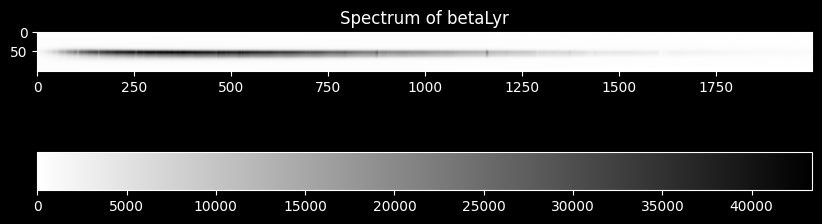

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/giove/giove_alpy_26072022_0116.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-25T23:05:38 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	7.0 \ Exposure time in seconds
EXPOSURE =	7.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	1.0 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning factor in wid

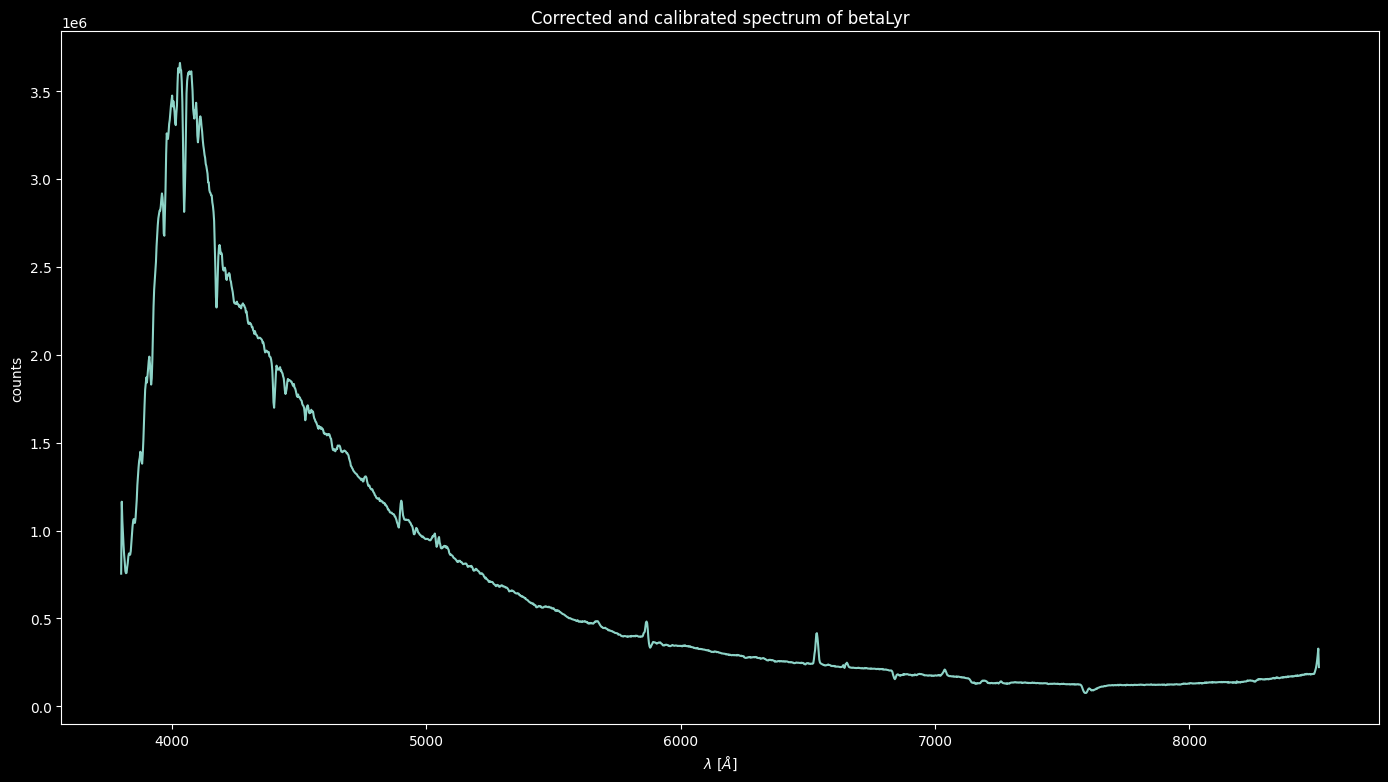

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/01_night/vega/vega_alby_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-26T01:25:25 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	5.0 \ Exposure time in seconds
EXPOSURE =	5.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-9.96 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Binning factor in wid

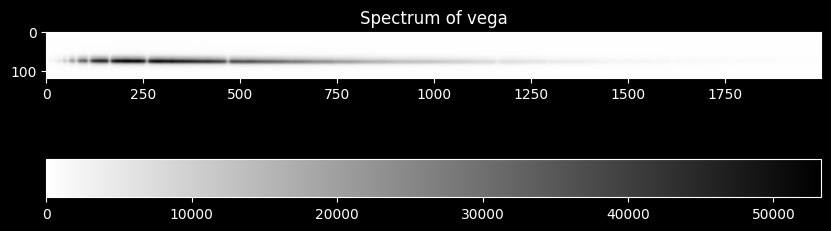

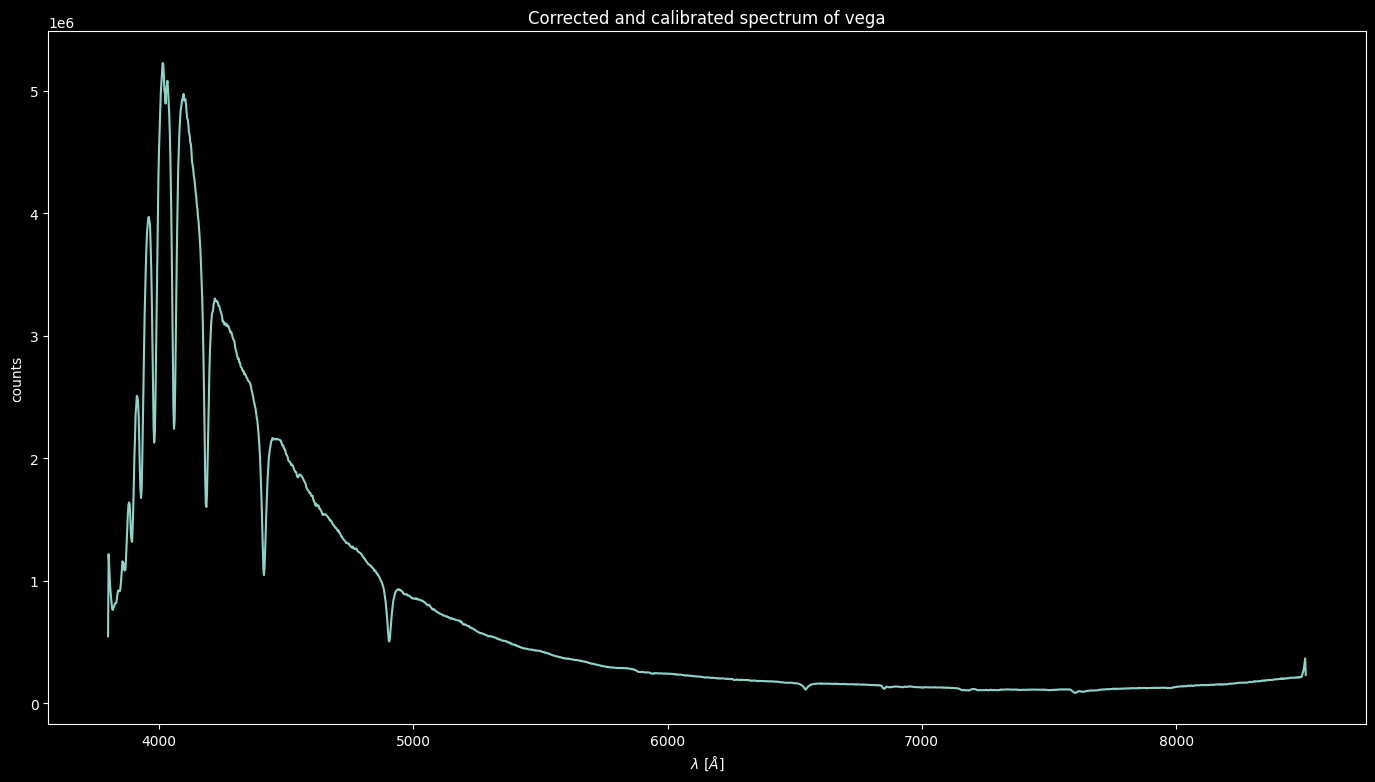

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/03_night/vega/vega_echelle_28072022_0206.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
 - HEADER -
SIMPLE =	True
BITPIX =	16 \ 8 unsigned int, 16 & 32 int, -32 & -64 real
NAXIS =	2 \ number of axes
NAXIS1 =	2749 \ fastest changing axis
NAXIS2 =	2199 \ next to fastest changing axis
BSCALE =	1.0 \ physical = BZERO + BSCALE*array_value
BZERO =	32768.0 \ physical = BZERO + BSCALE*array_value
DATE-OBS =	2022-07-28T00:04:33 \ YYYY-MM-DDThh:mm:ss observation start, UT
EXPTIME =	60.0 \ Exposure time in seconds
EXPOSURE =	60.0 \ Exposure time in seconds
SET-TEMP =	-20.0 \ CCD temperature setpoint in C
CCD-TEMP =	-12.370000000000001 \ CCD temperature at start of exposure in C
XPIXSZ =	4.54 \ Pixel Width in microns (after binning)
YPIXSZ =	4.54 \ Pixel Height in microns (after binning)
XBINNING =	1 \ Bi

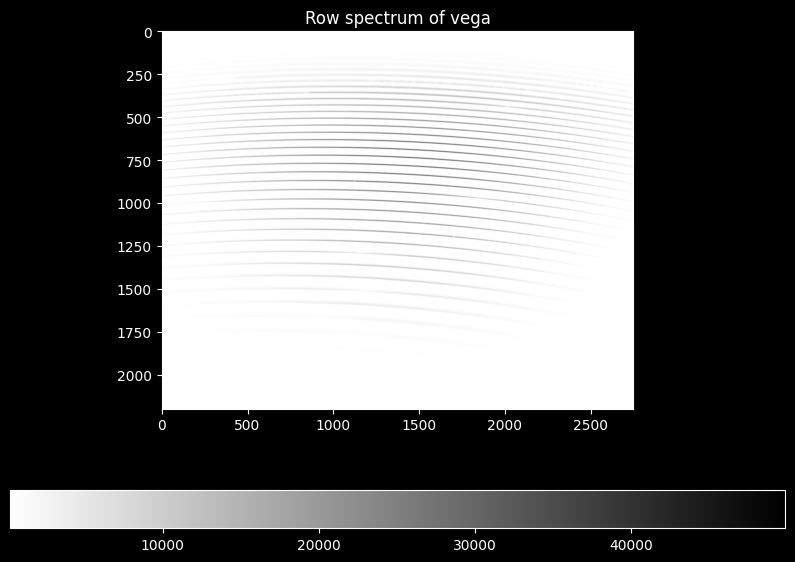

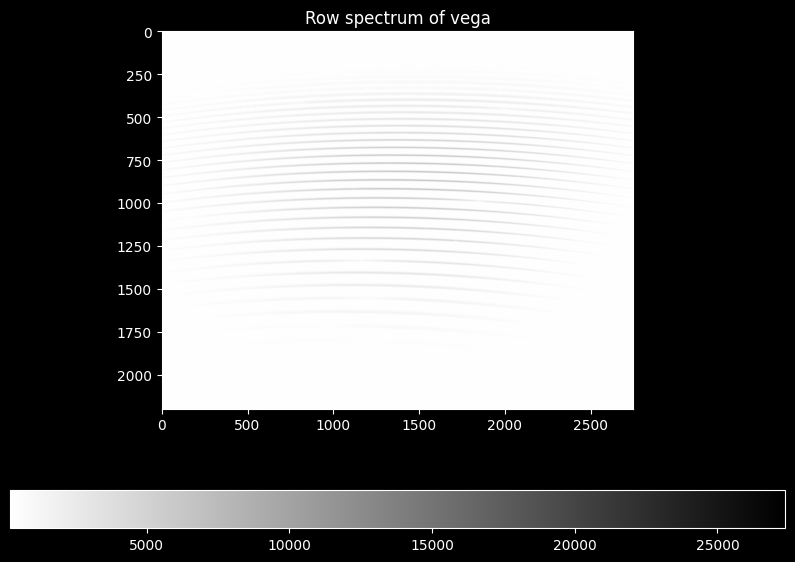

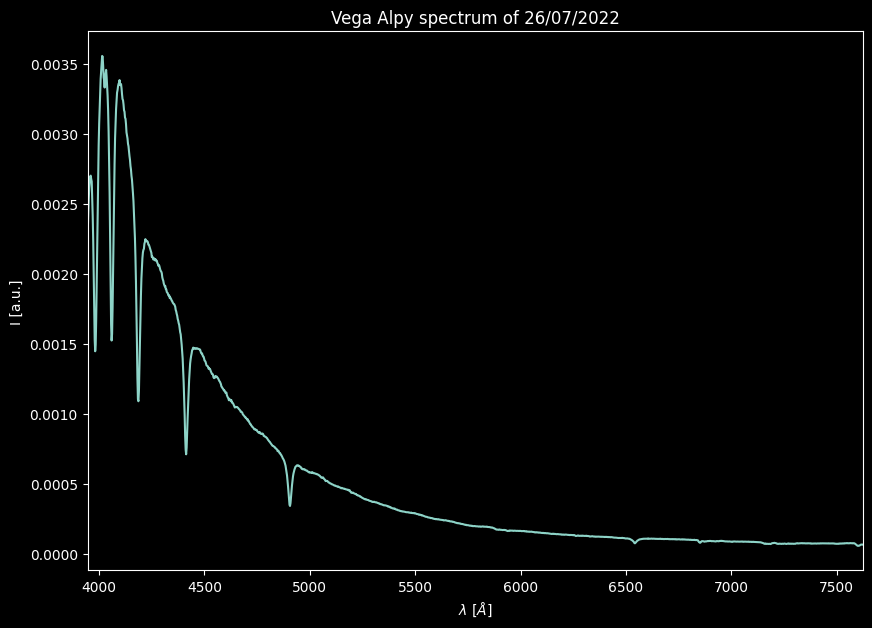

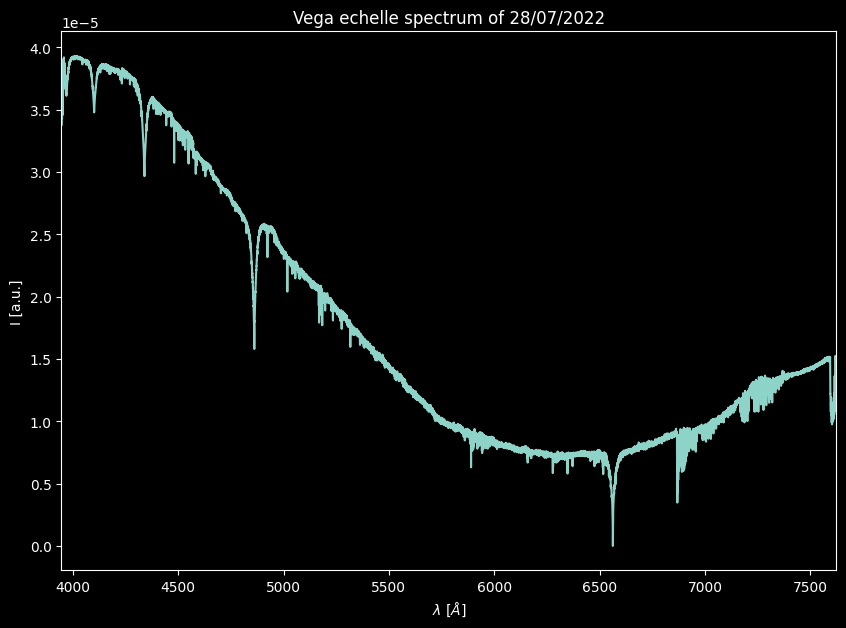

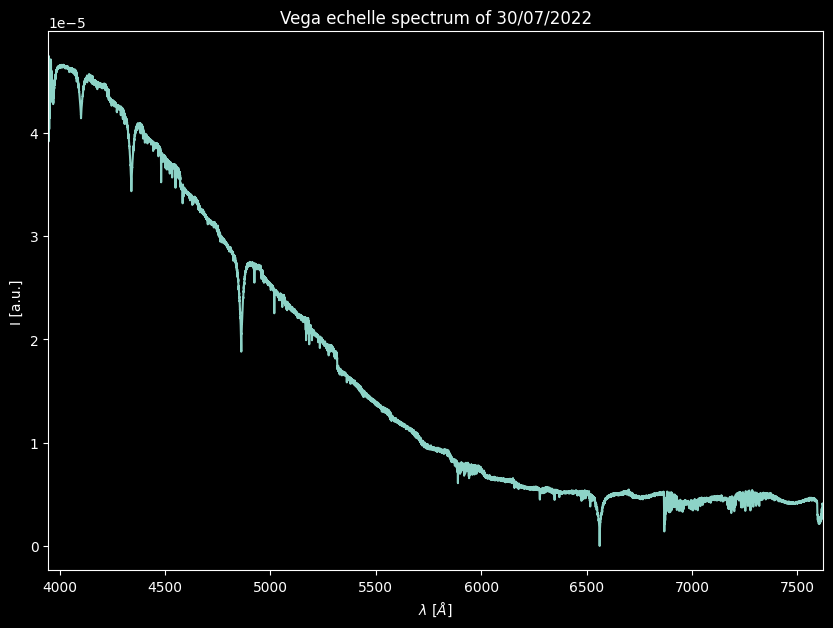

In [78]:
## loading alpy data for Vega
# getting `cal_func` and `flat_value` from Beta Lyrae
_, _, _, _, flat_value, cal_func = calibrated_spectrum(0,'betaLyr')
# calibrating data of Vega
hdul26, sp_data, flux26, wl26, _, _ = calibrated_spectrum(0,'vega',flat_value,cal_func)

# selecting Vega as target
echelle_path_file = os.path.join(DATA_FOLDER,'chosen_echelle_data','vega')
wl28, flux28 = np.loadtxt(os.path.join(echelle_path_file,'vega28.txt'), unpack=True)
wl30, flux30 = np.loadtxt(os.path.join(echelle_path_file,'vega30.txt'), unpack=True)

# echelle hdul informations
obj_fit, _, _ = extract_data(2,'vega')
hdul28, _ = get_data_fit(obj_fit, title='Row spectrum of vega', n=1, display_plots=True)
obj_fit, _, _ = extract_data(4,'vega')
hdul30, _ = get_data_fit(obj_fit, title='Row spectrum of vega', n=2, display_plots=True)

plt.show()

flux28 -= flux28.min()
flux30 -= flux30.min()

fastplot(wl26,flux26/flux26.sum(),1,title='Vega Alpy spectrum of 26/07/2022',labels=['$\lambda$ [$\AA$]','I [a.u.]'])
plt.xlim(min(wl28[0],wl30[0]),max(wl28[-1],wl30[-1]))
fastplot(wl28,flux28/abs(flux28.sum()),2,title='Vega echelle spectrum of 28/07/2022',labels=['$\lambda$ [$\AA$]','I [a.u.]'])
plt.xlim(min(wl28[0],wl30[0]),max(wl28[-1],wl30[-1]))
fastplot(wl30,flux30/abs(flux30.sum()),3,title='Vega echelle spectrum of 30/07/2022',labels=['$\lambda$ [$\AA$]','I [a.u.]'])
plt.xlim(min(wl28[0],wl30[0]),max(wl28[-1],wl30[-1]))

plt.show()


## <a id='toc1_4_'></a>[IV Flux normalization](#toc0_)

### <a id='toc1_4_1_'></a>[IV.1 Zero Airmass Intensity](#toc0_)